Script to explore the data produced in the first version of the workflow.
I will prob delete this, but I wanted to explore my old results to see where I need to make fixes.

In [26]:
# packages
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import sys
import os

In [9]:
# importing NWI metrics produced in old version
# right now these are stored on an external, in the future this will change with more efficient workflow

usa = geopandas.read_file('E:/SDSU_GEOG/Thesis/Data/US states/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
camels_nwi = geopandas.read_file("E:/SDSU_GEOG/Thesis/Data/NWI_outputs/Shapefiles/Metrics_CAMELS/nwi_metrics_camels.shp")
# print(camels_nwi)

# there are some NaNs for some reason
nan_values = camels_nwi['fresh'].isna().sum()
print(nan_values)

15


In [40]:
# dropping duplicates and resetting index
camels_nwi_2 = camels_nwi.drop_duplicates(subset='hru_id')
camels_nwi_2.reset_index(drop=True, inplace=True)
# checking data again
print(camels_nwi_2.describe())

# why are there only 417 watersheds????
# why do some values have NaN??? I don't see any NaN when I load the shapfiles in ArcGIS Pro

# dropping the NaN in 'fresh' for now so I can explore the data
camels_nwi_3 = camels_nwi_2.dropna(subset=['fresh'])
print(camels_nwi_3.describe())
print(camels_nwi_3)

          lon_cen     lat_cen    shed_area_       fresh        lake  \
count  417.000000  417.000000    417.000000  414.000000  218.000000   
mean   -89.109945   38.729920    638.730249    0.053739    0.005265   
std     14.969514    4.993266   1125.980989    0.101121    0.018731   
min   -124.174180   27.115580      6.104755    0.000011    0.000001   
25%    -92.481520   35.405200    127.874924    0.003913    0.000373   
50%    -83.514670   38.526890    285.793028    0.012146    0.001023   
75%    -79.026620   41.964240    683.870572    0.052996    0.002952   
max    -68.073130   48.874550  14271.028341    0.696283    0.251978   

            other       est  
count  417.000000  3.000000  
mean     0.011499  0.000038  
std      0.009085  0.000042  
min      0.000556  0.000001  
25%      0.006635  0.000015  
50%      0.009602  0.000029  
75%      0.012531  0.000056  
max      0.079137  0.000084  
          lon_cen     lat_cen    shed_area_       fresh        lake  \
count  414.000000  

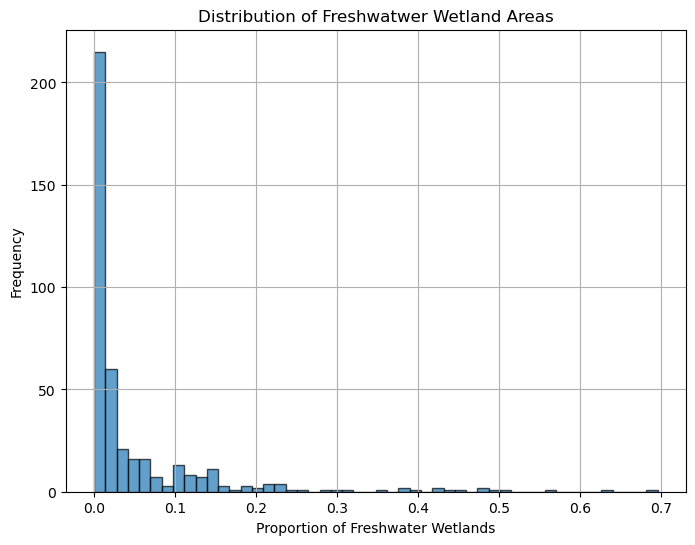

In [22]:
# explore the values
# first looking at the distribution

# Plot the distribution using a histogram
plt.figure(figsize=(8, 6))
plt.hist(camels_nwi_3['fresh'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Proportion of Freshwater Wetlands')
plt.ylabel('Frequency')
plt.title('Distribution of Freshwatwer Wetland Areas')
plt.grid(True)
plt.show()

C:\Users\holta\anaconda3\envs\wetland_metrics\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


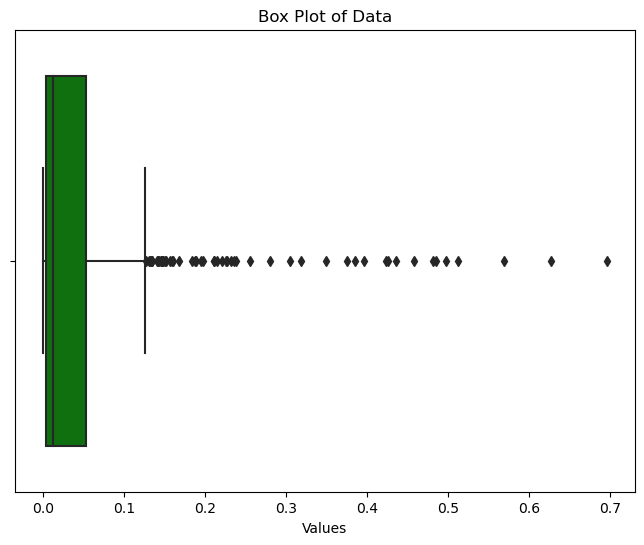

In [12]:
# now box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=camels_nwi_3['fresh'], color='green')
plt.xlabel('Values')
plt.title('Box Plot of Data')
plt.show()

In [20]:
# calculate skewness of data
skewness = skew(camels_nwi_3['fresh'])
print(skewness)

# definitley a skewed dataset

3.2821358597583425


Notes for self. I should be able to calcualte NWI wetland metrics for watersheds across the US, not just CAMELS watersheds. In that case, then I can compare the distribution of CAMELS wetland metrics to the general distribution of wetland metrics across the United States to see how representative the CAMELS watersheds are of wetlands.

### SIGNATURE CORRELATIONS ###

Initial explorations into the relationship between 'fresh' wetland metric and baseflow signatures from TOSSH toolbox.

In [36]:
# Get the absolute path of the directory containing this script
script_dir = os.path.dirname(os.path.abspath('__file__'))
print(script_dir)

# Append the parent directory of your_project to the Python path
parent_dir = os.path.abspath(os.path.join(script_dir, ".."))
parent_dir_2 = os.path.abspath(os.path.join(parent_dir, ".."))
sys.path.append(parent_dir_2)
print(parent_dir_2)

# Remove the parent directory from the Python path to avoid conflicts
sys.path.remove(parent_dir_2)

# Now you can import the function from another_script.py
# I needed to reinstall some packages, used this so saving for now: 
# https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html

from baseflow_prediction.signatures.calculate_sigs_camels import get_sig_df

C:\Users\holta\Documents\Repositories\wetland_metrics\libs
C:\Users\holta\Documents\Repositories


In [38]:
# path of previously created dataset
pi_path = 'C:/Users/holta/Documents/Repositories/baseflow_prediction/signatures/camels_gw_sigs_pi.obj'
# path of Toolbox
tossh_path = 'C:/Users/holta/Documents/Repositories/TOSSH'

# get data for hydrologic signatures
sigs = get_sig_df(tossh_path, pi_path)
print(sigs)

index                                  int64
gauge_id                              object
gauge_lat                            float64
gauge_lon                            float64
TotalRR                              float64
TotalRR_error_str                     object
EventRR                              float64
EventRR_error_str                     object
RR_Seasonality                       float64
RR_Seasonality_error_str              object
StorageFraction                       object
StorageFraction_error_str             object
Recession_a_Seasonality              float64
Recession_a_Seasonality_error_str     object
AverageStorage                       float64
AverageStorage_error_str              object
RecessionParameters                   object
RecessionParameters_error_str         object
MRC_num_segments                     float64
MRC_num_segments_error_str            object
BFI                                  float64
BFI_error_str                         object
BaseflowRe

In [43]:
# combine datasets

nwi_sigs = camels_nwi_3.merge(sigs, left_on='hru_id', right_on='gauge_id', how='inner')
nwi_sigs.sort_values(by='hru_id', ascending=False)
print(nwi_sigs)

       hru_id   lon_cen   lat_cen   shed_area_     fresh      lake     other  \
0    02342933 -85.41945  32.02590   290.045115  0.095017  0.001411  0.005634   
1    02361000 -85.46480  31.58780  1779.331144  0.106167  0.000355  0.005105   
2    02363000 -85.65737  31.86853  1292.639523  0.131536  0.000376  0.005808   
3    02369800 -86.66848  31.08605   231.140262  0.147121       NaN  0.003828   
4    02371500 -85.98757  31.86585  1257.447749  0.112378  0.000462  0.006195   
..        ...       ...       ...          ...       ...       ...       ...   
409  03180500 -79.74170  38.60639   346.491412  0.039467  0.000537  0.035103   
410  03182500 -79.87662  38.39219  1364.887916  0.018307  0.000136  0.016296   
411  03186500 -80.28160  38.32717   332.119946  0.004690       NaN  0.009469   
412  03187500 -80.36093  38.26585   207.997753  0.012646       NaN  0.008638   
413  03213700 -81.81715  37.42337  2431.417123  0.000720  0.000077  0.010502   

     est                               

Correlation coefficient: 0.06820907684119369


C:\Users\holta\anaconda3\envs\wetland_metrics\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\holta\anaconda3\envs\wetland_metrics\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


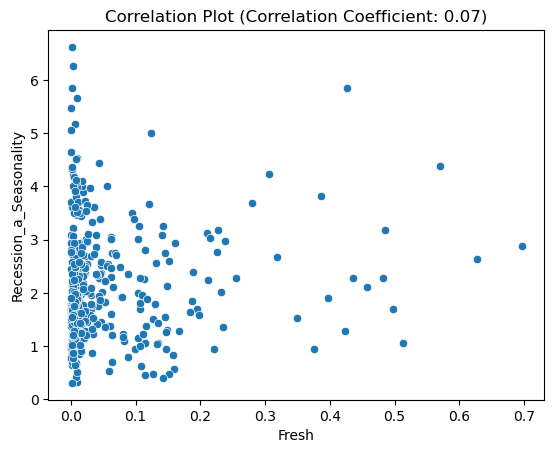

In [51]:
# correlation plots

correlation_coefficient = nwi_sigs['fresh'].corr(nwi_sigs['Recession_a_Seasonality'])
print("Correlation coefficient:", correlation_coefficient)

# Create a scatterplot with a regression line
sns.scatterplot(data=nwi_sigs, x='fresh', y='Recession_a_Seasonality')

# Set plot title and labels
plt.title(f'Correlation Plot (Correlation Coefficient: {correlation_coefficient:.2f})')
plt.xlabel('Fresh')
plt.ylabel('Recession_a_Seasonality')

# Show the plot
plt.show()